In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"

In [1]:
# import estimator class
from estimators.rnnEstimator import RnnEstimator
from estimators.kalmanEstimator import KalmanEstimator

#import rewarder class
from rewarders.thresholdRewarder import ThresholdRewarder

from matplotlib import pyplot
from utils.sequences_treatment import *
from utils.agent_treatment import *
from utils.plots import *

# import functions from Keras for the RNN
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN#, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packag

In [2]:
# Set parameters
T=12

estimatorType='rnn' # kalman or rnn
generatorType='linearSystem' # used only if compatible with the estimator type

seeAction=True
seeMeasurement=True
seeEstimate=False
seeTime=False

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 20)          1920      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
dense_1 (Dense)              (None, None, 2)           42        
Total params: 5,242
Trainable params: 5,242
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 400 samples, validate on 100 samples
Epoch 1/5
 - 20s - loss: 55.8534 - val_loss: 36.8768
Epoch 2/5
 - 15s - loss: 31.8234 - val_loss: 25.3216
Epoch 3/5
 - 15s - loss: 22.6773 - val_loss: 19.5911
Epoch 4/5
 - 15s - loss: 17.5536 - val_loss: 15.5865
Epoch 5/5
 - 15s - loss: 1

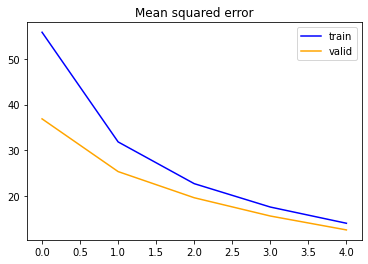

Done


In [3]:
if estimatorType=='rnn':
    # construct and train a Sequential RNN model with keras
    numberSamples_trainRNN=500
    T_trainRNN=T

    # generate sequences for training
    (objectives_trainRNN,measurements_trainRNN)=generateSequence(T_trainRNN,numberSamples=numberSamples_trainRNN,generatorType=generatorType)
    sigmas_trainRNN=randomSigma(T_trainRNN,numberSamples=numberSamples_trainRNN,p0=0.2)
    measurements_corrupted_trainRNN=corruptSequence_outOfRange(measurements_trainRNN,sigmas_trainRNN)
    inputRNN=np.concatenate((np.expand_dims(sigmas_trainRNN,2),measurements_corrupted_trainRNN),axis=2)

    n_dim_meas=np.shape(measurements_corrupted_trainRNN)[2]
    n_dim_obj=np.shape(objectives_trainRNN)[2]

    model=Sequential()
    model.add(LSTM(20,input_shape=(None,n_dim_meas+1),return_sequences=True))
    model.add(LSTM(20,return_sequences=True))
    model.add(Dense(n_dim_obj,activation=None))

    model.compile(optimizer='adam',loss='mean_squared_error')
    model.summary()

    # train the RNN
    history=model.fit(x=inputRNN,y=objectives_trainRNN,batch_size=1,epochs=5,validation_split=0.2,verbose=2)

    # plot loss
    plotRNNresults(history)
print('Done')

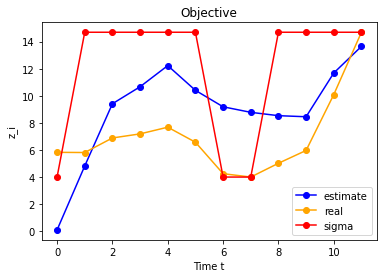

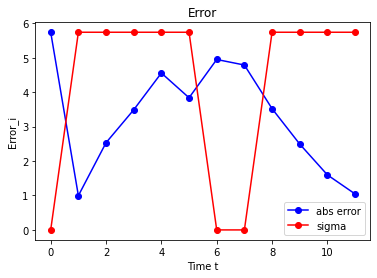

Done


In [4]:
if estimatorType=='rnn':
    idx_sample=2
    estimates_trainRNN=model.predict(inputRNN)
    plotExperiment(objectives_trainRNN, estimates_trainRNN, sigmas_trainRNN,idx_sample=idx_sample)
print('Done')

In [5]:
# construct estimator
if estimatorType=='rnn':
    estimator=RnnEstimator(model,generatorType,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime)
elif estimatorType=='kalman':
    estimator=KalmanEstimator(seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime)
else:
    print('ERROR: no valid estimatorType')
    
estimator.summarize()
print()

# contruct rewarder
rewarder=ThresholdRewarder(threshold=2, cost=50, windowSize=4)
rewarder.summarize()

RNN estimator
  generatorType: linearSystem
  observationsDimensions: [(5,), (5, 2)]
  seeAction= True
  seeMeasurement= True
  seeEstimate= False
  seeTime= False

Threshold rewarder
  window size: 4
  threshold: 2
  cost: 50
  number of measures in the window: 0


In [6]:
# generate sequences for training and validating the agent
numberSamples_train=100
T_train=T

numberSamples_valid=numberSamples_train
T_valid=T_train

(objectives_train,measurements_train)=estimator.generateSequence(T_train,numberSamples=numberSamples_train)
(objectives_valid,measurements_valid)=estimator.generateSequence(T_valid,numberSamples=numberSamples_valid)

print('shape training objectives:',np.shape(objectives_train))
print('shape training measurements:',np.shape(measurements_train))
print('shape validating objectives:',np.shape(objectives_valid))
print('shape validating measurements:',np.shape(measurements_valid))

shape training objectives: (100, 12, 2)
shape training measurements: (100, 12, 2)
shape validating objectives: (100, 12, 2)
shape validating measurements: (100, 12, 2)


In [7]:
# construct agent
agent=constructAgent(estimator,rewarder,objectives_train,measurements_train,objectives_valid,measurements_valid)
print('Agent constructed')

Environment parameters
  inputDimensions= [(5,), (5, 2)]
Sequences parameters
  outOfRangeValue= -1
  n_dim_obj= 2
  n_dim_meas= 2
  numberSamples_train 100
  numberSamples_valid 100
RNN estimator
  generatorType: linearSystem
  observationsDimensions: [(5,), (5, 2)]
  seeAction= True
  seeMeasurement= True
  seeEstimate= False
  seeTime= False
Threshold rewarder
  window size: 4
  threshold: 2
  cost: 50
  number of measures in the window: 0
Agent constructed


In [8]:
# Train agent
agent.resumeTrainingMode() # not required
agent.run(n_epochs=5, epoch_length=numberSamples_train*T_train)
cumulatedRewards_valid=agent._controllers[2].rewards
print('Agent Trained')

Average (on the epoch) training loss: 20.59666633605957
Episode average V value: -21.698530197143555
Average (on the epoch) training loss: 14.412796974182129
Episode average V value: -39.52003272374471
Average (on the epoch) training loss: 13.737985610961914
Episode average V value: -144.64247131347656
Average (on the epoch) training loss: 13.775617599487305
Episode average V value: -16.298572142918903
Average (on the epoch) training loss: 17.466835021972656
Episode average V value: -19.483482360839844
Average (on the epoch) training loss: 23.908018112182617
Episode average V value: -73.3212907964533
Average (on the epoch) training loss: 28.40923309326172
Episode average V value: -143.70652770996094
Average (on the epoch) training loss: 31.479036331176758
Episode average V value: -96.12061659495036
Average (on the epoch) training loss: 32.50159454345703
Episode average V value: -45.62263870239258
Average (on the epoch) training loss: 33.7502326965332
Episode average V value: -54.440118

Average (on the epoch) training loss: 24.618854522705078
Episode average V value: -57.75254853566488
Average (on the epoch) training loss: 24.614028930664062
Episode average V value: -75.76775391896565
Average (on the epoch) training loss: 24.789701461791992
Episode average V value: -100.32891082763672
Average (on the epoch) training loss: 24.947263717651367
Episode average V value: -110.13601875305176
Average (on the epoch) training loss: 24.97151756286621
Episode average V value: -124.60604095458984
Average (on the epoch) training loss: 25.043106079101562
Episode average V value: -95.17247708638509
Average (on the epoch) training loss: 25.052749633789062
Episode average V value: -89.60095977783203
Average (on the epoch) training loss: 25.115266799926758
Episode average V value: -101.95520782470703
Average (on the epoch) training loss: 25.14539909362793
Episode average V value: -96.09798494974773
Average (on the epoch) training loss: 25.20843505859375
Episode average V value: -111.402

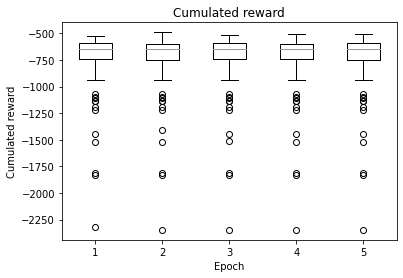

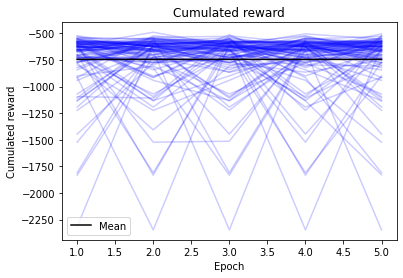

/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting

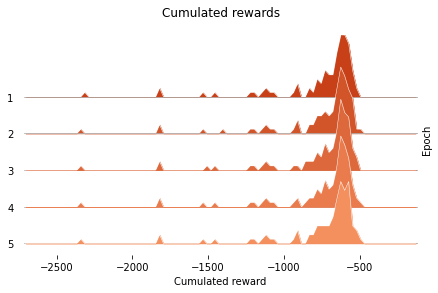

In [9]:
# plot validation
boxplotCumulatedRewards(cumulatedRewards_valid)
plotAllCumulatedRewards(cumulatedRewards_valid)
allHistoCumulatedRewards(cumulatedRewards_valid)

In [10]:
# generate test data
numberSamples_test=20
T_test=T
(objectives_test,measurements_test)=estimator.generateSequence(T_test,numberSamples=numberSamples_test)

# Results of the inference on test data
(sigmas_test,rewards_test,estimates_test)=agentInference(agent,objectives_test,measurements_test)
print('Test results computed')

Test results computed


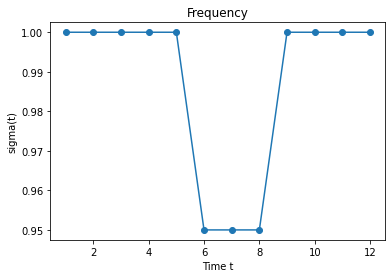

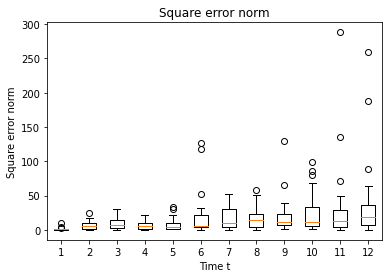

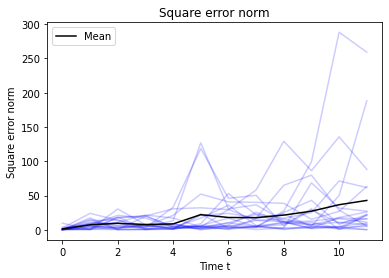

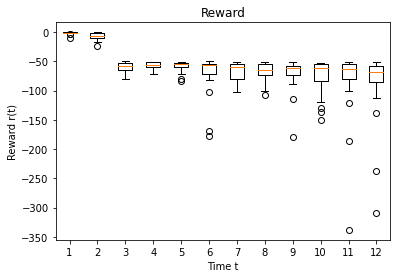

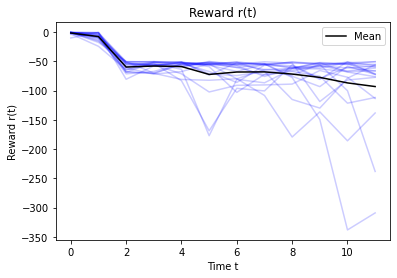

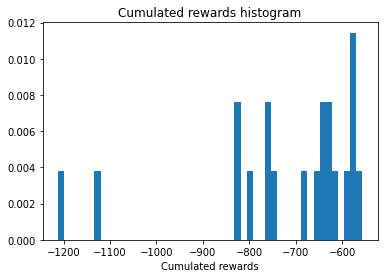

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.,

In [11]:
# plot test
idx_sample=5
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_test)
boxplotErrors(objectives_test,estimates_test)
plotAllErrors(objectives_test,estimates_test)
boxplotRewards(rewards_test)
plotAllRewards(rewards_test)
histoCumulatedRewards(rewards_test)
sigmas_test

In [12]:
# regular run on test data
numberMeasurements=5

# compute regular sigma (with same dim than validation data)
sigmas_regular=regularSigma(T_valid,numberMeasurements,numberSamples=numberSamples_test)

(rewards_regular, estimates_regular)=agentForcedInference(agent, sigmas_regular)
print('Done.')

Done.


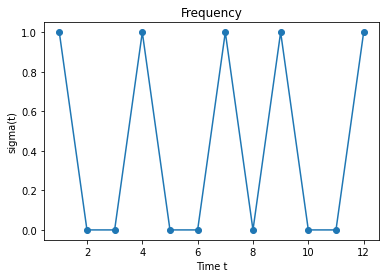

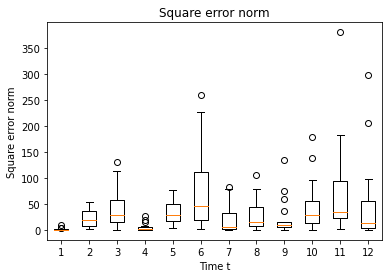

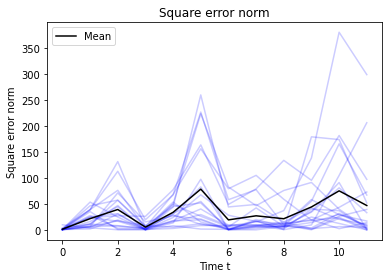

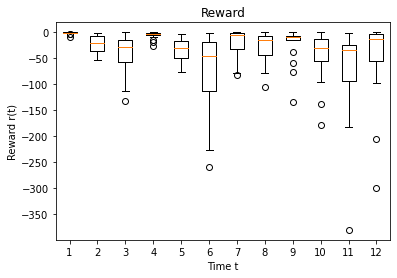

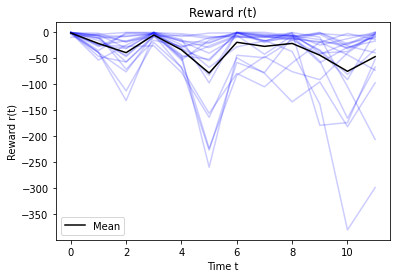

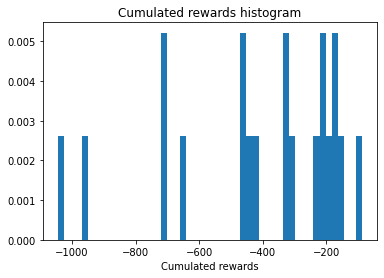

In [13]:
# plot test
idx_sample=5
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_regular)
boxplotErrors(objectives_test,estimates_regular)
plotAllErrors(objectives_test,estimates_regular)
boxplotRewards(rewards_regular)
plotAllRewards(rewards_regular)
histoCumulatedRewards(rewards_regular)

In [14]:
"""
import importlib
import utils.agent_treatment
importlib.reload(utils.agent_treatment)
from utils.agent_treatment import *
"""

'\nimport importlib\nimport utils.agent_treatment\nimportlib.reload(utils.agent_treatment)\nfrom utils.agent_treatment import *\n'